In [1]:
import os
import sys
import random
import math
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
from scipy.ndimage import zoom

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.autograd import Variable


from tensorflow.python.client import device_lib

In [2]:
#데이터 셋 가져오기
def get_mask_data():

    x_train_path = "dataset/Image_Segmentation/x_train2.npy"
    x_val_path = "dataset/Image_Segmentation/x_val2.npy" 
    y_train_path = "dataset/Image_Segmentation/y_train2.npy"
    y_val_path = "dataset/Image_Segmentation/y_val2.npy"
    
    x_train = np.load(x_train_path)
    x_val = np.load(x_val_path)
    y_train = np.load(y_train_path)
    y_val = np.load(y_val_path)

    print(x_train.shape, y_train.shape)
    print(x_val.shape, y_val.shape)
    
        
    return x_train, y_train, x_val, y_val


In [3]:
# CNN 인 VGG16 U-net
def VGG16_Unet(x_train, y_train, x_val, y_val) :
  
    inputs = Input(shape=(256, 256, 1))

    #down sampling 
    filters = 16       #feature map 수
    kernel_size = 3    # kernel size
    copy_layers = []   # Encoder에 있는 Activation map을 저장하는 리스트
    net = inputs
  
    #Encoder1
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #첫번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder2 
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #두번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder3
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #세번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder4
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #네번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #Encoder5
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #다섯번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #128
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    
    #Decoder : upsampling
    j = len(copy_layers) - 1
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #다섯번째 Activation map 
    
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    j = j -1 

    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #네번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #세번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #두번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #첫번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    outputs = Conv2D(2, 1, activation='sigmoid') (net)




    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adamax', loss='binary_crossentropy', 
                  metrics=['acc',tf.keras.metrics.MeanIoU(num_classes=2)])

    model.summary()
    
    
    

    return model

In [4]:
def training(model,x_train, y_train, x_val, y_val) :
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=16, 
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)])
    fig, ax = plt.subplots(3, 2, figsize=(10, 7))
    plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

    
    ax[0, 0].set_title('loss')
    ax[0, 0].plot(history.history['loss'], 'r')
    ax[0, 1].set_title('acc')
    ax[0, 1].plot(history.history['acc'], 'b')

    ax[1, 0].set_title('val_loss')
    ax[1, 0].plot(history.history['val_loss'], 'r--')
    ax[1, 1].set_title('val_acc')
    ax[1, 1].plot(history.history['val_acc'], 'b--')
    
    ax[2,0].set_title('MeanIoU')
    ax[2,0].plot(history.history['mean_io_u'], 'r')
    ax[2,1].set_title('val_MeanIoU')
    ax[2,1].plot(history.history['val_mean_io_u'], 'r')
    

#     preds = model.predict(x_val)
#     fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
#     temp = np.empty((256, 256, 1), dtype=np.float32)

#     for i in range(40):
#         ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
#         ax[i, 0].title.set_text(str(i))
    
#         y_val_0 = y_val[...,0]
#         ax[i, 1].imshow(y_val_0[i].squeeze(), cmap='gray')
    
#         predict_0 = preds[...,0]
#         ax[i, 2].imshow(predict_0[i].squeeze(), cmap='gray')
    
#         temp = x_val[i]
#         pred_sum = predict_0[i][predict_0[i] > 0]
#         pred_mean = np.mean(predict_0)
#         if(np.min(temp) >= 0) :
#             temp[predict_0[i] < 0.5] = 0
#         else :
#             temp[predict_0[i] < 0.5] = -2048
#         ax[i, 3].imshow(temp.squeeze(), cmap='gray')


In [5]:
x_train, y_train, x_val, y_val = get_mask_data()
print(y_train.max(), y_train.min())
print(x_train.max(), x_train.min())
print(x_val.max(), x_val.min())
# model = VGG16_Unet(x_train, y_train2, x_val, y_val2)
# history = training(model,x_train, y_train2, x_val, y_val2)

(2675, 256, 256, 1) (2675, 256, 256, 2)
(298, 256, 256, 1) (298, 256, 256, 2)
1 0
1.0 0.0
1.0 0.0


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d_1[0][0]                   
______________________________________________________________________________________________

Epoch 1/30
168/168 [==============================] - 88s 469ms/step - loss: 0.2674 - acc: 0.9608 - mean_io_u: 0.2500 - val_loss: 0.3979 - val_acc: 0.8673 - val_mean_io_u: 0.2500
Epoch 2/30
168/168 [==============================] - 73s 437ms/step - loss: 0.0786 - acc: 0.9944 - mean_io_u: 0.2509 - val_loss: 0.4337 - val_acc: 0.8700 - val_mean_io_u: 0.2500
Epoch 3/30
168/168 [==============================] - 73s 437ms/step - loss: 0.0372 - acc: 0.9956 - mean_io_u: 0.2626 - val_loss: 0.0706 - val_acc: 0.9825 - val_mean_io_u: 0.2517
Epoch 4/30
168/168 [==============================] - 73s 437ms/step - loss: 0.0239 - acc: 0.9961 - mean_io_u: 0.2872 - val_loss: 0.0210 - val_acc: 0.9953 - val_mean_io_u: 0.2818
Epoch 5/30
168/168 [==============================] - 73s 437ms/step - loss: 0.0180 - acc: 0.9962 - mean_io_u: 0.3017 - val_loss: 0.0182 - val_acc: 0.9953 - val_mean_io_u: 0.2897
Epoch 6/30
168/168 [==============================] - 73s 437ms/step - loss: 0.0150 - acc: 0.9963 - mean_

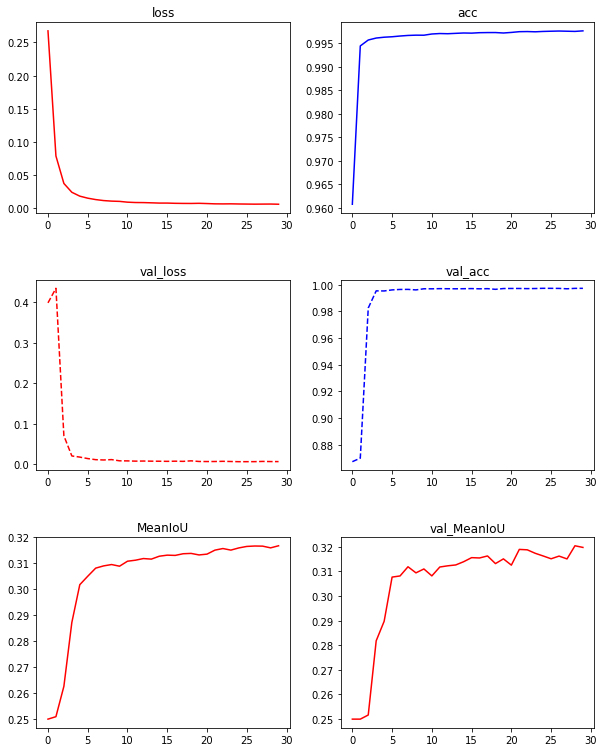

In [6]:
model = VGG16_Unet(x_train, y_train, x_val, y_val)
history = training(model,x_train, y_train, x_val, y_val)

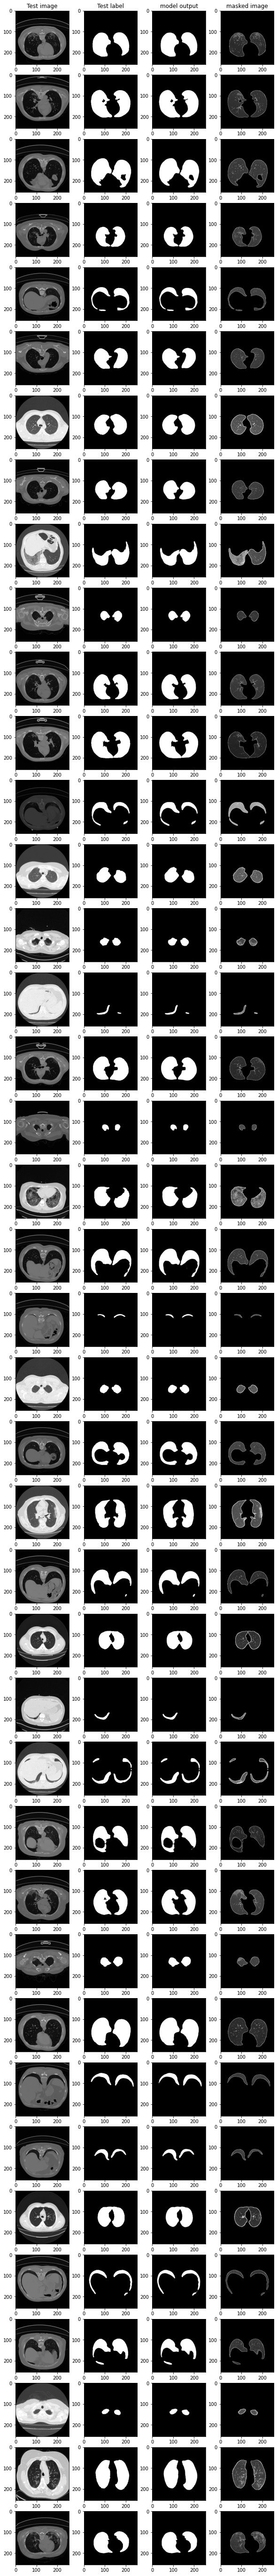

In [7]:
preds = model.predict(x_val)
fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
temp = np.empty((256, 256, 1), dtype=np.float32)

ax[0, 0].title.set_text("Test image")
ax[0, 1].title.set_text("Test label")
ax[0, 2].title.set_text("model output")
ax[0, 3].title.set_text("masked image")
for i in range(40):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    
    y_val_0 = y_val[...,0]
    ax[i, 1].imshow(y_val_0[i].squeeze(), cmap='gray')
    
    predict_0 = preds[...,0]
    ax[i, 2].imshow(predict_0[i].squeeze(), cmap='gray')
    
    temp = x_val[i]
    pred_sum = predict_0[i][predict_0[i] > 0]
    pred_mean = np.mean(predict_0)
    temp[predict_0[i] < 0.5] = 0
    ax[i, 3].imshow(temp.squeeze(), cmap='gray')
    

In [8]:
y_val_com_0 = y_val[...,0] #image label 
predict_com_0 = preds[...,0] #prediction (model output)

IOU_SUM = 0.0
IOU_AVE = 0.0
Number_image =0

for n,_ in enumerate(y_val_com_0) :
    
    TP = 0
    NP = 0
    index = n
    
    y_label_image = y_val_com_0[index].copy()
    predict_image = predict_com_0[index].copy()

    #model output 0번째 사진의 각 픽셀에 0.5보다 작으면 0 크면 1
    predict_image[predict_image < 0.5] = 0 
    predict_image[predict_image > 0.5] = 1

    #비교 해서 같으면 TP+1 아니면 NP+1
    for i in range(256) :
        for j in range(256) :
            if(y_label_image[i][j] == predict_image[i][j]) :
                TP = TP + 1
            else :
                NP = NP + 1

    print('Number : ', n, 'TP :', TP,'NP : ', NP)
    print('IOU :', TP/ (TP + NP) , '\n')
    IOU_SUM = TP/ (TP + NP) + IOU_SUM
    Number_image = n
    
IOU_AVE = IOU_SUM / (Number_image +  1)
print("IOU_AVE : ", IOU_AVE)


Number :  0 TP : 65388 NP :  148
IOU : 0.99774169921875 

Number :  1 TP : 65365 NP :  171
IOU : 0.9973907470703125 

Number :  2 TP : 65178 NP :  358
IOU : 0.994537353515625 

Number :  3 TP : 65394 NP :  142
IOU : 0.997833251953125 

Number :  4 TP : 65381 NP :  155
IOU : 0.9976348876953125 

Number :  5 TP : 65418 NP :  118
IOU : 0.998199462890625 

Number :  6 TP : 65437 NP :  99
IOU : 0.9984893798828125 

Number :  7 TP : 65468 NP :  68
IOU : 0.99896240234375 

Number :  8 TP : 65263 NP :  273
IOU : 0.9958343505859375 

Number :  9 TP : 65472 NP :  64
IOU : 0.9990234375 

Number :  10 TP : 65385 NP :  151
IOU : 0.9976959228515625 

Number :  11 TP : 65281 NP :  255
IOU : 0.9961090087890625 

Number :  12 TP : 65243 NP :  293
IOU : 0.9955291748046875 

Number :  13 TP : 65411 NP :  125
IOU : 0.9980926513671875 

Number :  14 TP : 65391 NP :  145
IOU : 0.9977874755859375 

Number :  15 TP : 65490 NP :  46
IOU : 0.999298095703125 

Number :  16 TP : 65361 NP :  175
IOU : 0.9973297119

Number :  137 TP : 65473 NP :  63
IOU : 0.9990386962890625 

Number :  138 TP : 65517 NP :  19
IOU : 0.9997100830078125 

Number :  139 TP : 65481 NP :  55
IOU : 0.9991607666015625 

Number :  140 TP : 65315 NP :  221
IOU : 0.9966278076171875 

Number :  141 TP : 65279 NP :  257
IOU : 0.9960784912109375 

Number :  142 TP : 65468 NP :  68
IOU : 0.99896240234375 

Number :  143 TP : 65346 NP :  190
IOU : 0.997100830078125 

Number :  144 TP : 65269 NP :  267
IOU : 0.9959259033203125 

Number :  145 TP : 65373 NP :  163
IOU : 0.9975128173828125 

Number :  146 TP : 65279 NP :  257
IOU : 0.9960784912109375 

Number :  147 TP : 65266 NP :  270
IOU : 0.995880126953125 

Number :  148 TP : 65446 NP :  90
IOU : 0.998626708984375 

Number :  149 TP : 65525 NP :  11
IOU : 0.9998321533203125 

Number :  150 TP : 65277 NP :  259
IOU : 0.9960479736328125 

Number :  151 TP : 65396 NP :  140
IOU : 0.99786376953125 

Number :  152 TP : 65377 NP :  159
IOU : 0.9975738525390625 

Number :  153 TP : 65

Number :  273 TP : 65349 NP :  187
IOU : 0.9971466064453125 

Number :  274 TP : 65452 NP :  84
IOU : 0.99871826171875 

Number :  275 TP : 65352 NP :  184
IOU : 0.9971923828125 

Number :  276 TP : 65427 NP :  109
IOU : 0.9983367919921875 

Number :  277 TP : 65452 NP :  84
IOU : 0.99871826171875 

Number :  278 TP : 65331 NP :  205
IOU : 0.9968719482421875 

Number :  279 TP : 65391 NP :  145
IOU : 0.9977874755859375 

Number :  280 TP : 65460 NP :  76
IOU : 0.99884033203125 

Number :  281 TP : 65176 NP :  360
IOU : 0.9945068359375 

Number :  282 TP : 65302 NP :  234
IOU : 0.996429443359375 

Number :  283 TP : 65204 NP :  332
IOU : 0.99493408203125 

Number :  284 TP : 65351 NP :  185
IOU : 0.9971771240234375 

Number :  285 TP : 65203 NP :  333
IOU : 0.9949188232421875 

Number :  286 TP : 65328 NP :  208
IOU : 0.996826171875 

Number :  287 TP : 65299 NP :  237
IOU : 0.9963836669921875 

Number :  288 TP : 65131 NP :  405
IOU : 0.9938201904296875 

Number :  289 TP : 65269 NP : 